In [28]:
import numpy as np
import cv2

# Add any python libraries here
import sys
import argparse
from matplotlib import pyplot as plt
from skimage.feature import corner_peaks

#Helper funcs
def cvt_for_plt(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

def plot_corners(img,corner_score_img=None,points=None):
    if corner_score_img is None and points is None:
        return
    img_corners = np.copy(img)
    if corner_score_img is not None:
        img_corners[corner_score_img>0.01*corner_score_img.max()] = [0,0,255]
        print(np.sum(corner_score_img>0.01*corner_score_img.max()))
    elif points is not None:
        print(np.shape(points))
        img_corners[tuple(points.T)] = [0,0,255]
    plt.imshow(cvt_for_plt(img_corners))
    
    
    

#Parameters
## corner Detection
ch_block_size = 4
ch_ksize = 5
ch_k = 0.04
anms_local_maxima_threshold = 0.01


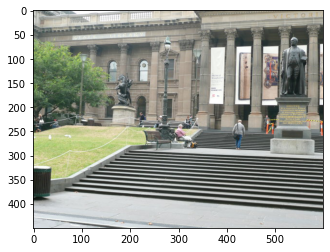

In [22]:
base_path = '../Data/Train/'
img_set = 'Set1/'
img_sequence = '3'
img1_color_orig = cv2.imread(base_path + img_set + img_sequence + '.jpg')
img1_gray = cv2.cvtColor(img1_color_orig,cv2.COLOR_BGR2GRAY)
plt.imshow(cvt_for_plt(img1_color_orig))

6099
-0.015474993


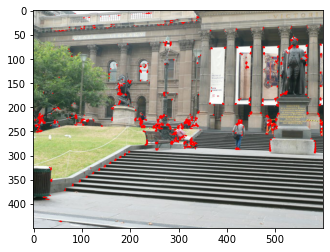

In [15]:

cornersOfImg = cv2.cornerHarris(img1_gray,ch_block_size,ch_ksize,ch_k)
n_harris_corners = np.sum(cornersOfImg>0.01*cornersOfImg.max())
plot_corners(img1_color_orig,cornersOfImg)
print(cornersOfImg.mean())

In [29]:
## ANMS
from functools import total_ordering


@total_ordering
class CoOrds:
    def __init__(self,x,y):
        self.x = int(x)
        self.y = int(y)
        self.distance_score = sys.float_info.max
    def __lt__(self,obj):
        return ((self.distance_score) < (obj.distance_score))
    def __repr__(self) -> str:
        return "(x,y,distance):("+str(self.x)+","+str(self.y)+","+str(self.distance_score)+")"

def apply_anms_to_img(corner_score_img,n_best,anms_local_maxima_threshold):
    local_maxima_coords = corner_peaks(corner_score_img,indices=True,threshold_abs=anms_local_maxima_threshold)

    # initializing distances array
    distances = np.full(local_maxima_coords.shape[0],fill_value=CoOrds(0,0))
    for i,coords in enumerate(local_maxima_coords):
        distances[i] = CoOrds(coords[0],coords[1])


    ED = None
    for i,coord_i in enumerate(local_maxima_coords):
        for coord_j in local_maxima_coords:
            # print(i," ", corner_score_img[coord_j[0],coord_j[1]], " ", corner_score_img[coord_i[0],coord_i[1]])
            if (corner_score_img[coord_j[0],coord_j[1]] > corner_score_img[coord_i[0],coord_i[1]]):
                ED = np.power((coord_j[0] - coord_i[0]),2) + np.power((coord_j[1]-coord_i[1]),2)
            if ED is not None and ED < distances[i].distance_score:
                distances[i].distance_score = ED
    sort_distances_obj = np.array(sorted(distances,reverse=True))
    print(sort_distances_obj.shape)
    sort_distances_obj = sort_distances_obj[0:n_best]
    
    
    sorted_dists_mat = np.zeros(shape=(sort_distances_obj.shape[0],2)) 

    for i,dist in enumerate(sort_distances_obj):
        sorted_dists_mat[i] = np.array([int(sort_distances_obj[i].x), sort_distances_obj[i].y])
    return sorted_dists_mat.astype(int)

distances = apply_anms_to_img(cornersOfImg,int(n_harris_corners/1),anms_local_maxima_threshold)
print(distances.shape)

# plot_corners(img_corners,apply_anms_to_img(cornersOfImg,10))
# print(cornersOfImg[240:250,290:310])

(696,)
(696, 2)


(696, 2)


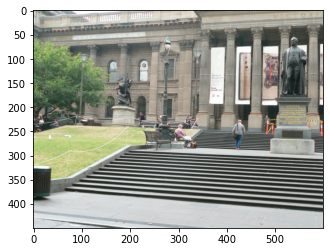

In [30]:
plot_corners(img1_color_orig,points=distances)